# 텐서플로 허브에서 사전 훈련된 MobileNet 모델 불러오기

In [1]:
import tensorflow_hub as hub
import tensorflow as tf

In [2]:
mobile_net_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

model = tf.keras.Sequential([
    hub.KerasLayer(handle=mobile_net_url, input_shape=(224, 224, 3), trainable=False)
])

model.summary()

Metal device set to: Apple M1


2022-02-25 11:39:13.154496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-25 11:39:13.154856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [3]:
# 그림 8.2 좌측 전체 네트워크 구조 출력 코드
from tensorflow.keras.applications import MobileNetV2

mobilev2 = MobileNetV2()
tf.keras.utils.plot_model(mobilev2)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# ImageNetV2-TopImages 불러오기

In [4]:
# 8.2 ImageNetV2-TopImages 불러오기
import os
import pathlib
from glob import glob

content_data_url = './content/sample_data'
data_root_orig = tf.keras.utils.get_file('imagenetV2', 'https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-top-images.tar.gz', cache_dir=content_data_url, extract=True)
data_root = pathlib.Path(glob("./content/sample_data/datasets/*/")[0])

print(data_root)

content/sample_data/datasets/imagenetv2-top-images-format-val


# 디렉토리 출력

In [5]:
for idx, item in enumerate(data_root.iterdir()):
    print(item)
    if idx == 9:
        break

content/sample_data/datasets/imagenetv2-top-images-format-val/797
content/sample_data/datasets/imagenetv2-top-images-format-val/909
content/sample_data/datasets/imagenetv2-top-images-format-val/135
content/sample_data/datasets/imagenetv2-top-images-format-val/307
content/sample_data/datasets/imagenetv2-top-images-format-val/763
content/sample_data/datasets/imagenetv2-top-images-format-val/551
content/sample_data/datasets/imagenetv2-top-images-format-val/61
content/sample_data/datasets/imagenetv2-top-images-format-val/95
content/sample_data/datasets/imagenetv2-top-images-format-val/338
content/sample_data/datasets/imagenetv2-top-images-format-val/936


# ImageNet 라벨 텍스트 불러오기

In [6]:
label_file = tf.keras.utils.get_file('label', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

label_text = None

with open(label_file, 'r') as f:
    label_text = f.read().split('\n')[:-1]
    
print(len(label_text))
print(label_text[:10])
print(label_text[-10:])

1001
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen']
['buckeye', 'coral fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen-of-the-woods', 'bolete', 'ear', 'toilet tissue']


# 이미지 확인

image_count: 10000


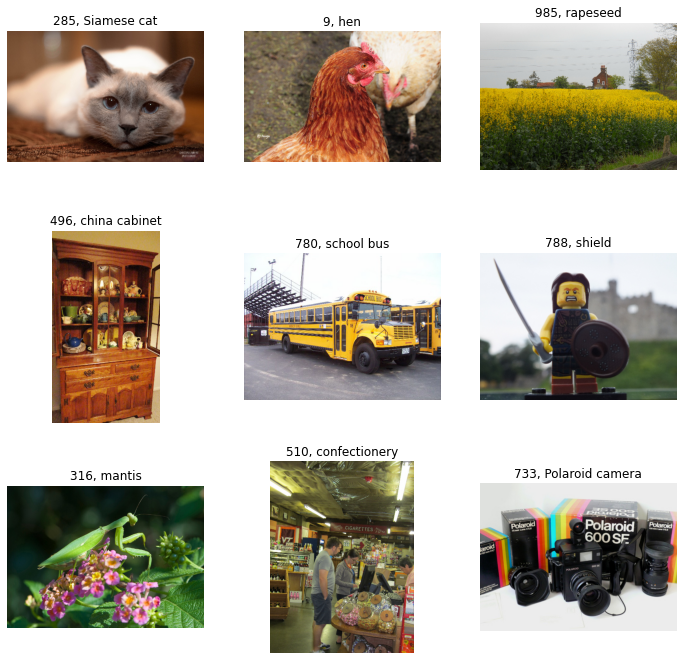

In [7]:
import PIL.Image as Image
import matplotlib.pyplot as plt
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# 이미지를 랜덤하게 섞는다.
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print('image_count:', image_count)

plt.figure(figsize=(12, 12))

for c in range(9):
    image_path = random.choice(all_image_paths)
    plt.subplot(3, 3, c+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
              
plt.show()

# MobileNet의 분류 성능 확인

In [15]:
import cv2
import numpy as np

top_1 = 0
top_5 = 0

for image_path in all_image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    top_5_predict = model.predict(img)[0].argsort()[::-1][:5]
    idx = int(image_path.split('/')[-2])+1
    if idx in top_5_predict:
        top_5 += 1
        if top_5_predict[0] == idx:
            top_1 += 1
            
print('Top-5 correctness:', top_5 / len(all_image_paths) * 100, '%')
print('Top-1 correctness:', top_1 / len(all_image_paths) * 100, '%')

2022-02-25 00:10:07.937396: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-25 00:10:08.037356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Top-5 correctness: 83.52000000000001 %
Top-1 correctness: 59.06 %


# argsort와 sort 사용법

In [9]:
import numpy as np
a = np.array([99, 32, 5, 64])
arg = np.argsort(a)

print(arg)
print(np.sort(a))
print(a[arg])

[2 1 3 0]
[ 5 32 64 99]
[ 5 32 64 99]


# MobileNet의 분류 라벨 확인

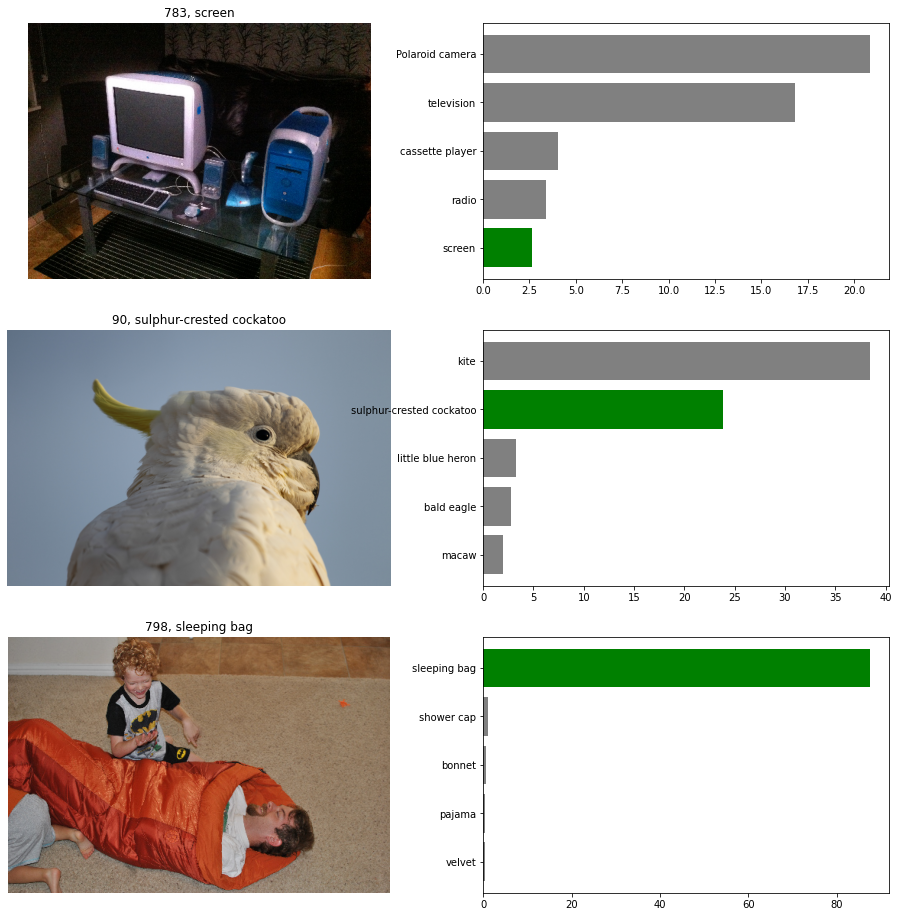

In [15]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(16, 16))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

for c in range(3):
    image_path = random.choice(all_image_paths)
    
    # 이미지 표시
    plt.subplot(3, 2, c*2+1)
    plt.imshow(plt.imread(image_path))
    idx = int(image_path.split('/')[-2]) + 1
    plt.title(str(idx) + ', ' + label_text[idx])
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3, 2, c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # MobileNet을 이용한 예측
    logits = model.predict(img)[0]
    prediction = softmax(logits)
    
    # 가장 높은 확률의 예측값 5개를 뽑는다.
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [label_text[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    
    color = color[::-1]
    
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])